In [1]:
%%html
<a href="https://colab.research.google.com/github/tejnica/creatoria-lite/blob/main/run_demo.py" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [2]:
# 📌 Creatoria-lite: minimal open-source design optimizer
#
# YAML → QUBO → Simulated Annealing → CSV → Pareto
#
# - 🔧 Binary options: `cell_thickness`, `fin_height`
# - 🎯 Objectives: maximize thermal conductivity (−λ), minimize mass
# - 🧊 Solver: `dwave-neal` (Simulated Annealing)
#
# Output: `results.csv`, Pareto chart `pareto.png`


In [3]:
!pip install -q pyqubo dwave-neal pymoo matplotlib pyyaml pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.3 MB/s eta 0:00:00


--2025-05-09 20:49:14--  https://raw.githubusercontent.com/tejnica/creatoria-lite/main/contradiction.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278 [text/plain]
Saving to: ‘contradiction.yaml’

contradiction.yaml  100%[===================>]     278  --.-KB/s    in 0s      

2025-05-09 20:49:14 (4.51 MB/s) - ‘contradiction.yaml’ saved [278/278]



,lambda_neg,mass
0,0.0,0
84,-0.7,60
220,-0.9,80


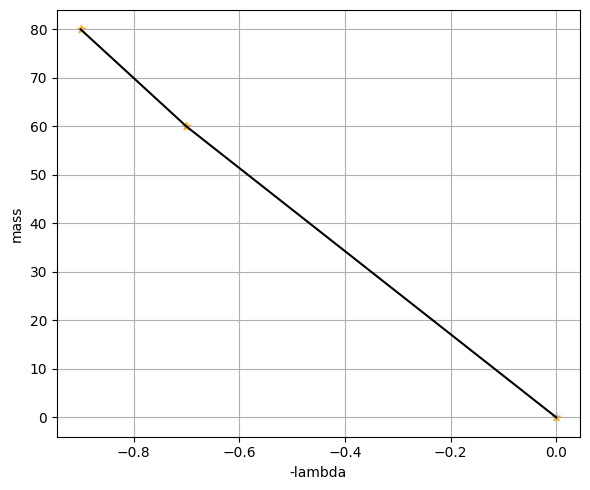

In [5]:
from pyqubo import Binary
import pandas as pd
import yaml
from neal import SimulatedAnnealingSampler
import matplotlib.pyplot as plt

# Build QUBO
def build_qubo(path='contradiction.yaml'):
    spec = yaml.safe_load(open(path))
    H = 0
    binaries = {}
    for name, cfg in spec["options"].items():
        x = Binary(name)
        binaries[name] = x
        H += cfg["weight"] * x + abs(cfg["effect_lambda"]) * x
    Q, _ = H.compile().to_qubo()
    return Q, binaries, spec

# Solve QUBO
def solve(n_reads=500):
    Q, binaries, spec = build_qubo()
    sampler = SimulatedAnnealingSampler()
    response = sampler.sample_qubo(Q, num_reads=n_reads, num_sweeps=2000)

    records = []
    var_order = list(binaries.keys())

    for sample, _ in zip(response.record.sample, response.record.energy):
        sel = dict(zip(var_order, sample))
        lambda_neg = 0
        mass = 0
        for name, bit in sel.items():
            cfg = spec["options"][name]
            lambda_neg += cfg["effect_lambda"] * bit
            mass += cfg["weight"] * bit
        records.append({"lambda_neg": lambda_neg, "mass": mass})

    df = pd.DataFrame(records)
    df.to_csv("results.csv", index=False)
    return df

# Plot Pareto
def plot():
    df = pd.read_csv("results.csv")
    df = df.drop_duplicates()

    pareto = df.sort_values(['lambda_neg', 'mass'], ascending=[True, True])
    pareto_front = [pareto.iloc[0]]
    for i in range(1, len(pareto)):
        if pareto.iloc[i]['mass'] < pareto_front[-1]['mass']:
            pareto_front.append(pareto.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)

    plt.figure(figsize=(6, 5))
    plt.scatter(df["lambda_neg"], df["mass"], color="orange", alpha=0.8, label="Candidates", marker="*")
    plt.plot(pareto_front["lambda_neg"], pareto_front["mass"], color="black", label="Pareto front")
    plt.xlabel("-lambda")
    plt.ylabel("mass")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pareto.png")

# Main: download YAML if needed
import os
if not os.path.exists("contradiction.yaml"):
    !wget https://raw.githubusercontent.com/tejnica/creatoria-lite/main/contradiction.yaml

df = solve()
plot()
df.drop_duplicates()



In [ ]:
from IPython.display import Image, display
display(Image("pareto.png"))


In [ ]:
with open("contradiction.yaml", "w") as f:
    f.write("""name: demo
objectives:
  - id: lambda_neg
    description: "минус теплопроводность"
  - id: mass
    description: "масса"
options:
  cell_thickness:
    bits: 1
    weight: 80
    effect_lambda: -0.9
  fin_height:
    bits: 1
    weight: 60
    effect_lambda: -0.7
""")
